# Setup

In [1]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from metrics import ConfusionMatrixGenerator
from joblib import dump
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'program_comprehension_challenge'
report_dict_list = []

# Evenly distribute the training data labelled as "No" and "Yes".

In [2]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

X_train_evenly_dist = evenly_distrubted_training_dataset[FEATURES]
y_train_evenly_dist = evenly_distrubted_training_dataset[LABEL]

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

,Label (Yes),Label (No),Ratio (Yes)
Training Dataset,92,506,0.153846
Test Dataset,39,111,0.260000


# Set up

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

# CountVectorizer - SVC

In [4]:
from sklearn.svm import SVC

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_count_vectorizer',
            CountVectorizer(stop_words='english'),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

clf_svc = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - SVC

In [5]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Stemming - SVC

In [6]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_count_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SVC

In [7]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True, ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=0.1, probability=True))
    ],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SGDClassifier

In [8]:
from sklearn.linear_model import SGDClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier(random_state=13))
    ],
    verbose=False)

clf_sgd = full_pipeline

clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_sgd.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - KNeighborsClassifier

In [9]:
from sklearn.neighbors import KNeighborsClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', KNeighborsClassifier())
    ],
    verbose=False)

clf_kneighbors = full_pipeline

clf_kneighbors.fit(X_train, y_train)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_kneighbors.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', BaggingClassifier(base_estimator=LogisticRegression(C=500000, solver='lbfgs'), max_samples=0.5, max_features=0.5))
    ],
    verbose=False)

clf_ensemble = full_pipeline

clf_ensemble.fit(X_train, y_train)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_ensemble.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression) (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - MultinomialNB

In [11]:
from sklearn.naive_bayes import MultinomialNB

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_multinominal_nb.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', RandomForestClassifier(max_features='auto', bootstrap=False, class_weight={'Yes': 0.2, 'No': 0.8}, random_state=20))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - LogisticRegression

In [13]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='liblinear', multi_class='ovr', intercept_scaling=1, dual=True, penalty='l2'))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - DecisionTree

In [14]:
from sklearn.tree import DecisionTreeClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier(random_state=1, min_samples_split=0.25))],
    verbose=False)

clf_decision_tree = full_pipeline

clf_decision_tree.fit(X_train, y_train)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_decision_tree.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# CodeComprehensionClassifierFactory

In [15]:
from classifier import CodeComprehensionClassifierFactory

clf_optimal = CodeComprehensionClassifierFactory.get_classifier(dac_labels)

clf_optimal.fit(X_train, y_train)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_optimal.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Report Performance Before Grid Search (as it is time consuming)

In [16]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,CountVectorizer - SVC,0.798450,0.927928,0.858333,0.619048,0.333333,0.433333,0.773333
1,CountVectorizer - SVC (Evenly Distributed),0.864583,0.747748,0.801932,0.481481,0.666667,0.559140,0.726667
2,TFIDF - SVC,0.768116,0.954955,0.851406,0.583333,0.179487,0.274510,0.753333
3,TFIDF - SVC (Evenly Distributed),0.876404,0.702703,0.780000,0.459016,0.717949,0.560000,0.706667
4,TFIDF - Stemming - SVC,0.767606,0.981982,0.861660,0.750000,0.153846,0.255319,0.766667
5,TFIDF - Stemming - SVC (Evenly Distributed),0.890411,0.585586,0.706522,0.402597,0.794872,0.534483,0.640000
6,TFIDF - Lemmatization - SVC,0.845528,0.936937,0.888889,0.740741,0.512821,0.606061,0.826667
7,TFIDF - Lemmatization - SVC (Evenly Distributed),0.897959,0.792793,0.842105,0.557692,0.743590,0.637363,0.780000
8,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.866667
9,TFIDF - Lemmatization - SGDClassifier (Evenly ...,0.885417,0.765766,0.821256,0.518519,0.717949,0.602151,0.753333


# Tuning the model with Grid Search

In [17]:
from joblib import dump

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            SGDClassifier()
        )
    ],
    verbose=False)

yes_f1_scorer = metrics.make_scorer(metrics.f1_score, pos_label='Yes')
yes_precision_scorer = metrics.make_scorer(metrics.precision_score, pos_label='Yes')
yes_fbeta_precision_scorer = metrics.make_scorer(metrics.fbeta_score, beta=0.5, pos_label='Yes')

grid_search_cv_params = [
    {
        # {'preprocessor__body_tfidf_vectorizer__tokenizer': [None, LemmaTokenizer()]},
        # {'preprocessor__body_tfidf_vectorizer__stop_words': [None, 'english']},
        # {'preprocessor__body_tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]},
        # 'preprocessor__transformer_weights': [
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 2},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 100},          
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 6},
        # ],
        # 'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        # 'classifier__penalty': ['l2', 'l1', 'elasticnet'],
        # 'classifier__learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'],
        # 'classifier__criterion': ['gini', 'entropy'],
        # 'classifier__splitter': ['best', 'random'],
        # 'classifier__max_depth': [None, 5, 10],
        # 'classifier__min_samples_split': [2, 0.1, 0.25, 1.0],
        # 'classifier__min_samples_leaf': [1, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
        # 'classifier__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
        # 'classifier__max_features': [None, 1, 'auto', 'sqrt', 'log2'],
        # 'classifier__ccp_alpha': [0.0, 1.0, 100.0],
        # 'classifier__class_weight': [None, 'balanced', {'Yes': 0.175, 'No': 0.825}],
        # 'classifier__early_stopping': [True, False],
        'classifier__random_state': list(range(1, 20)),
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
dump(clf_grid_search_cv, './models/program_comprehension_challenge_gridsearchcv.pickle')
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.8min finished


{'classifier__random_state': 18}

In [18]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.646681,1.700582,0.936447,1.651283,1,{'classifier__random_state': 1},0.722892,0.662651,0.518868,0.731707,0.806452,0.688514,0.096338,7,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
1,6.038259,3.214359,0.863380,1.510288,2,{'classifier__random_state': 2},0.783133,0.630631,0.566038,0.555556,0.755814,0.658234,0.094791,15,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
2,3.570642,1.537153,0.873335,1.511138,3,{'classifier__random_state': 3},0.733333,0.630631,0.508475,0.731707,0.833333,0.687496,0.110097,9,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
3,3.645190,1.564411,0.951556,1.653313,4,{'classifier__random_state': 4},0.677966,0.695652,0.612245,0.743243,0.705128,0.686847,0.042980,10,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
4,3.852348,1.653609,0.940158,1.648297,5,{'classifier__random_state': 5},0.759494,0.700935,0.612245,0.743243,0.697674,0.702718,0.051146,3,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
5,3.890752,1.681207,0.955691,1.676498,6,{'classifier__random_state': 6},0.634921,0.632184,0.471014,0.645161,0.757576,0.628171,0.091427,19,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
6,4.012379,1.742587,1.031590,1.803271,7,{'classifier__random_state': 7},0.696203,0.631579,0.570175,0.614035,0.725806,0.647560,0.056314,16,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
7,4.050839,1.744419,0.958062,1.661661,8,{'classifier__random_state': 8},0.783133,0.656566,0.611111,0.648148,0.862069,0.712205,0.094772,2,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
8,3.793182,1.624451,0.886423,1.550702,9,{'classifier__random_state': 9},0.746269,0.630631,0.590909,0.731707,0.725806,0.685064,0.062305,11,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000
9,3.648432,1.576125,0.906317,1.567844,10,{'classifier__random_state': 10},0.714286,0.630631,0.570175,0.689655,0.833333,0.687616,0.088305,8,1.0,1.0,1.0,1.0,1.00000,1.000000,0.000000


In [19]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [20]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,CountVectorizer - SVC,0.798450,0.927928,0.858333,0.619048,0.333333,0.433333,0.773333
1,CountVectorizer - SVC (Evenly Distributed),0.864583,0.747748,0.801932,0.481481,0.666667,0.559140,0.726667
2,TFIDF - SVC,0.768116,0.954955,0.851406,0.583333,0.179487,0.274510,0.753333
3,TFIDF - SVC (Evenly Distributed),0.876404,0.702703,0.780000,0.459016,0.717949,0.560000,0.706667
4,TFIDF - Stemming - SVC,0.767606,0.981982,0.861660,0.750000,0.153846,0.255319,0.766667
5,TFIDF - Stemming - SVC (Evenly Distributed),0.890411,0.585586,0.706522,0.402597,0.794872,0.534483,0.640000
6,TFIDF - Lemmatization - SVC,0.845528,0.936937,0.888889,0.740741,0.512821,0.606061,0.826667
7,TFIDF - Lemmatization - SVC (Evenly Distributed),0.897959,0.792793,0.842105,0.557692,0.743590,0.637363,0.780000
8,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.866667
9,TFIDF - Lemmatization - SGDClassifier (Evenly ...,0.885417,0.765766,0.821256,0.518519,0.717949,0.602151,0.753333


# GridSearch with Evenly Distributed Dataset

In [21]:
clf_grid_search_cv.fit(X_train_evenly_dist, y_train_evenly_dist)
dump(clf_grid_search_cv, './models/program_comprehension_challenge_gridsearchcv_evenly_distributed.pickle')
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    5.9s finished


{'classifier__random_state': 9}

In [22]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.213148,0.012561,0.074539,0.020015,1,{'classifier__random_state': 1},0.872093,0.867347,0.808081,0.808081,0.744681,0.820056,0.046717,10,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
1,0.246098,0.020027,0.056355,0.015066,2,{'classifier__random_state': 2},0.888889,0.765306,0.789474,0.794393,0.744681,0.796548,0.049493,18,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
2,0.209390,0.005371,0.041605,0.003524,3,{'classifier__random_state': 3},0.853659,0.904255,0.720721,0.949367,0.707547,0.827110,0.097177,7,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
3,0.208666,0.008256,0.048976,0.008391,4,{'classifier__random_state': 4},0.797872,0.849057,0.808081,0.776699,0.813953,0.809132,0.023652,16,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
4,0.224501,0.011635,0.051907,0.006049,5,{'classifier__random_state': 5},0.857143,0.867347,0.824176,0.862069,0.722222,0.826591,0.054317,8,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
5,0.244271,0.008830,0.042225,0.004103,6,{'classifier__random_state': 6},0.853659,0.904255,0.720721,0.789474,0.744681,0.802558,0.068076,17,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
6,0.232640,0.004423,0.042931,0.005745,7,{'classifier__random_state': 7},0.765306,0.914634,0.808081,0.824176,0.777778,0.817995,0.052667,11,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
7,0.210414,0.006730,0.040444,0.002978,8,{'classifier__random_state': 8},0.797872,0.988372,0.769231,0.949367,0.722222,0.845413,0.104387,2,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
8,0.222525,0.006936,0.045879,0.005594,9,{'classifier__random_state': 9},0.914634,0.944444,0.789474,0.963855,0.744681,0.871418,0.087775,1,1.0,1.0,1.0,1.0,1.000000,1.00000,0.00000
9,0.218723,0.010997,0.041677,0.003998,10,{'classifier__random_state': 10},0.797872,0.904255,0.804598,0.842105,0.615385,0.792843,0.096431,19,1.0,1.0,1.0,1.0,0.958549,0.99171,0.01658


In [23]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [24]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,CountVectorizer - SVC,0.798450,0.927928,0.858333,0.619048,0.333333,0.433333,0.773333
1,CountVectorizer - SVC (Evenly Distributed),0.864583,0.747748,0.801932,0.481481,0.666667,0.559140,0.726667
2,TFIDF - SVC,0.768116,0.954955,0.851406,0.583333,0.179487,0.274510,0.753333
3,TFIDF - SVC (Evenly Distributed),0.876404,0.702703,0.780000,0.459016,0.717949,0.560000,0.706667
4,TFIDF - Stemming - SVC,0.767606,0.981982,0.861660,0.750000,0.153846,0.255319,0.766667
5,TFIDF - Stemming - SVC (Evenly Distributed),0.890411,0.585586,0.706522,0.402597,0.794872,0.534483,0.640000
6,TFIDF - Lemmatization - SVC,0.845528,0.936937,0.888889,0.740741,0.512821,0.606061,0.826667
7,TFIDF - Lemmatization - SVC (Evenly Distributed),0.897959,0.792793,0.842105,0.557692,0.743590,0.637363,0.780000
8,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.866667
9,TFIDF - Lemmatization - SGDClassifier (Evenly ...,0.885417,0.765766,0.821256,0.518519,0.717949,0.602151,0.753333


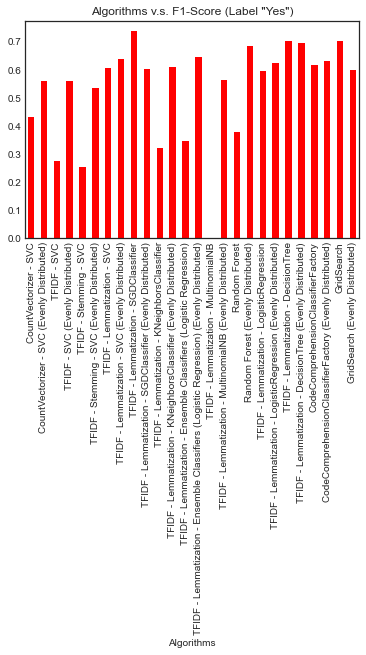

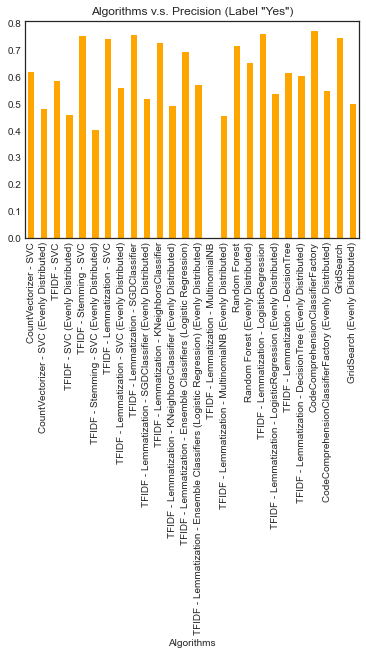

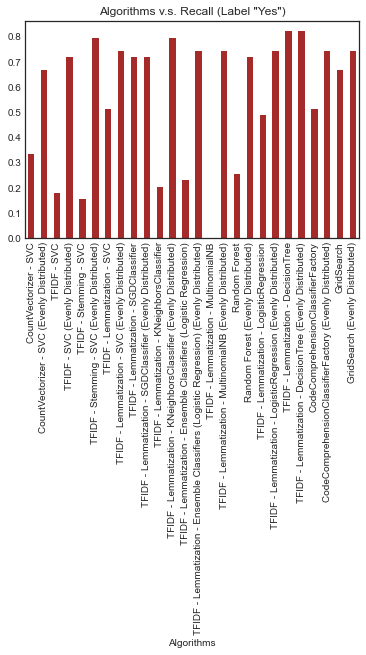

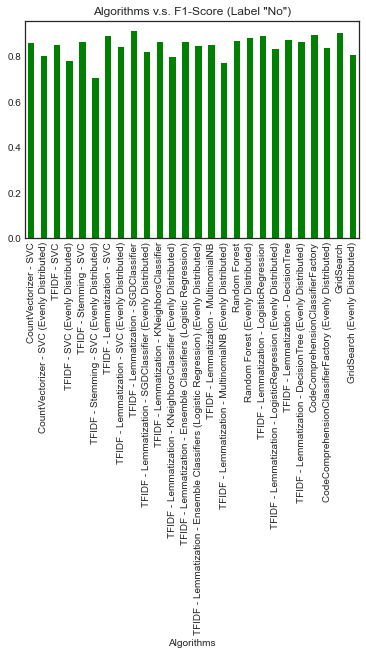

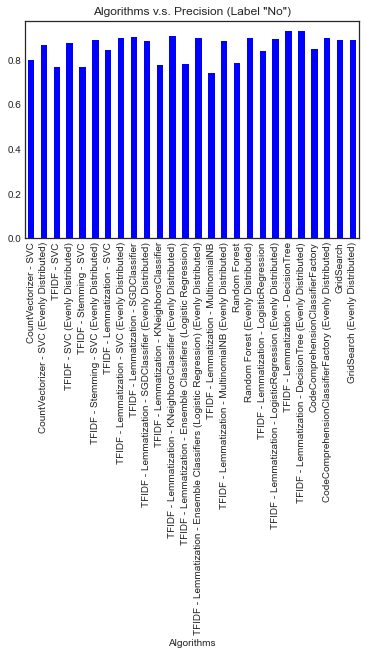

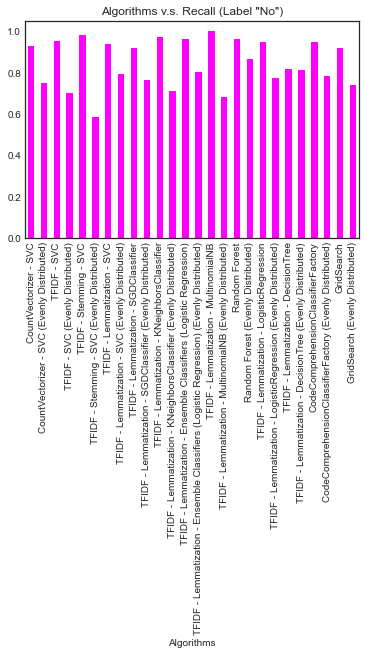

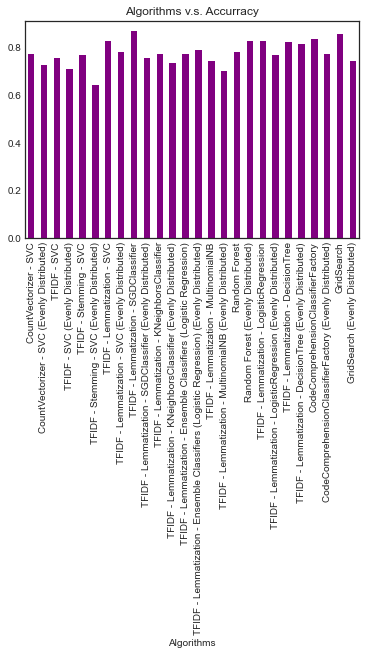

In [25]:
from matplotlib import pyplot

with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)